In [21]:
#Code for binary search to more efficiently calculate Hausdorff dimension

In [22]:
!pip install mne

In [23]:
import math as mth
import mne as mne
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt

In [24]:
#Parameters
  #P: nxd ndarray of n d-dimensional datapoints
  #s: real nonegative float s
#Returns:
  #discSEnergy: Float containing the discrete-s energy of P
  #s parameter

def DiscreteSEnergy(P, s):
  n = np.shape(P)[0]

  [Rows, Columns] = np.indices((n,n))

  VecDiff = np.abs(P[Rows,:] - P[Columns,:])

  MagDiff = np.power(np.sum(np.power(VecDiff,2), axis=2),1/2) #here we use L2 norm (Euclidean distance in Rd) to find vector magnitude

  Diff= np.triu(MagDiff) #remove duplicate differences by considering only those differences above the main diagonal
  MaskedDiff = ma.masked_where(Diff==0, Diff, copy=True) #mask all zero differences so we are not dividing by zero

  SumMat = np.ma.power(MaskedDiff, -s)
  sum = np.sum(np.sum(SumMat))

  discSEnergy = np.power(float(n), -2)*sum
  return[discSEnergy, s]

In [25]:
#Parameters
  #n: positive integer representing number of samples
  #t: postive float representing length of time interval [0,t] samples are scaled to (I default to t=1)
  #h: float greater than 0 and less than 1 representing the Hurst Exponent, which uniquely specifies an dBM distribution. h=1/2 yields classic Brownian motion
#Returns:
  #fBM: an (n,1) dimensional nparray of fractional brownian motion samples generated with Hurst exponent h using Cholesky's Method,
  #timeArray: an (n,1) dimensional array of times each sample is taken at
  #h: the input hurst exponent parameter

def FBM(n, t, h):
  CovMat = np.ones((n, n)) #covariance matrix of the Gaussian series (X1 = fB_h(1), X2= fB_h(2)-fB_h(1),..., XN = fB_h(N)-fB_h(N-1)), called fractional Gaussian noise. These are easier to simulate as increments of fBM are stationary

  [Rows, Columns] = np.indices((n,n))
  AbsDiff = np.abs(Rows-Columns)

  ind = np.diag_indices_from(AbsDiff)
  AbsDiff[ind] = 1 #diagonal values don't matter so replace with one to avoid any possible square root of negative one errors

  CovMat = 1/2*(np.power(AbsDiff+1, 2*h) + np.power(AbsDiff-1, 2*h) - 2*np.power(AbsDiff, 2*h)) #covariance matrix of fractional Gaussian noise can be derived from the covariance matrix of fBM(fB_h(i)-fB_h(i-1), fB_h(j)-fB_h(j-1)) = i^2h + j^2h - |i-j|^2h

  ind = np.diag_indices_from(CovMat)
  CovMat[ind] = 1 #variance of each variable is one, so diagonal of covariance matrix must be one

  L = np.linalg.cholesky(CovMat)#covariance matricies are positive definite by construction so CovMat can be decomposed CovMat = LL' where L is lower triangular
  v = np.random.normal(0,1,(n,1)) #vector of independent standard normal variables
  fGN = np.dot(L,v)

  fBM = np.zeros((n, 1))
  timeArray = np.ones((n, 1))
  FBMMat = np.zeros((n,2))

  fBM[0,0] = fGN[0,0]
  for i in range (1,n):
    timeArray[i-1,0] = i*(t/n) # time each sample is taken at in the time interval [0,t]
    fBM[i,0] = fBM[i-1,0] + fGN[i,0]  #calculate Brownian motion as the cumulateive sum of the fGN increments up to that point


  fBM = np.power(t/n,h)*fBM #use self similarity property to scale samples down to a specific time interval

  FBMMat[:,0] = timeArray[:,0]
  FBMMat[:,1] = fBM[:,0]


  return [fBM, timeArray, FBMMat, h]

In [26]:
#Compute Discrete Energy Curves
#Parameters:
  #N: total length of time series
  #s: real nonegative float, parameter of discrete s energy
  #TimeMat: N x 2 ndarray where TimeMat[:,0] are the times and TimeMat[:,1] are the data values indexed by time

def DiscSEnergyCurves(maxN, s, TimeMat, noSamples):
  timeArray = TimeMat[:,0]
  dataArray = TimeMat[:,1]

  increment = mth.floor(maxN/noSamples)

  nArray  = np.zeros((noSamples,1))
  discSEnergyArray = np.zeros((noSamples,1))

  i = 0

  for n in range (increment, maxN+increment, increment):

    [indexFloat, ignore] = (maxN/n)*(np.indices((n,1)))
    indexFloat = np.floor((indexFloat))

    indexArray = indexFloat.astype('int')

    timeSubset = timeArray[indexArray]
    #print(timeSubset)
    timeSubset = timeSubset[:,0]

    dataSubset = dataArray[indexArray]
    dataSubset = dataSubset[:,0]

    TimeSubset = np.zeros((n,2))
    TimeSubset[:,0] = timeSubset
    TimeSubset[:,1] = dataSubset

    [discSEnergy, s] = DiscreteSEnergy(TimeSubset, s)

    nArray[i,0] = n
    discSEnergyArray[i,0] = discSEnergy

    i=i+1

  return [nArray, discSEnergyArray]

In [27]:
#Fractional Brownian Motion Discrete S Energy Curve Trials

maxN = 2**8
t = 1
h=1/2

s=2-h #expected critical value
#s =2 #s too large for any hurst exponent h in (0,1)
#s =1 #s too small for any hurst exponent h in (0,1)

[fBM, timeArray, FBMMat, h] = FBM(maxN,t,h)

noSamples = mth.floor(maxN/2)

[nArray, discSEnergyArray] = DiscSEnergyCurves(maxN, s, FBMMat, noSamples)

Text(0.5, 1.0, 'Discrete Energy Curve of Bh(t), s = 2 > 2-h = 2-0.5 = 1.5 ')

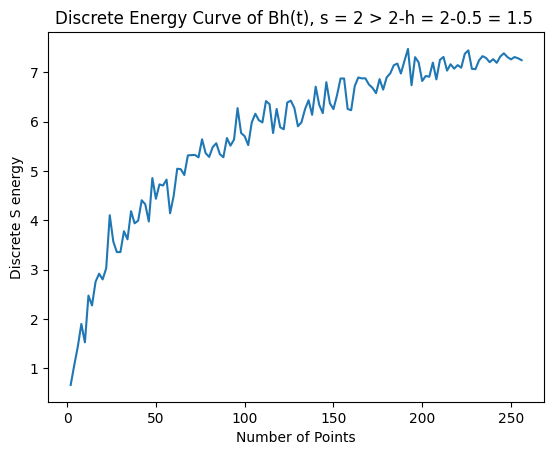

In [28]:
plt.plot(nArray, discSEnergyArray)
plt.xlabel('Number of Points')
plt.ylabel('Discrete S energy')
plt.title("Discrete Energy Curve of Bh(t), s = 2 > 2-h = 2-0.5 = 1.5 ")

In [29]:
#step 1 - isolate the seizure
#seizing from 1467 to 1494 seconds
mne.sys_info()
file = r"chb01_01.edf"

data = mne.io.read_raw_edf(file)

raw = data.get_data() #numpy array
raw_seiz = raw[:,1467*256:1494*256] #isolating specific times the patient is seizing, 256 bits of time in a seconds

info = data.info
channels=data.ch_names

#info = data2.info
#channels=data2.ch_names

#info = data3.info
#channels=data3.ch_names
#plt.plot(raw[0][:1000])

Platform             macOS-15.5-arm64-arm-64bit
Python               3.11.13 (main, Jun  5 2025, 08:21:08) [Clang 14.0.6 ]
Executable           /opt/anaconda3/envs/medical-data-processing/bin/python
CPU                  Apple M2 Pro (10 cores)
Memory               16.0 GiB

Core
├☑ mne               1.10.0 (latest release)
├☑ numpy             2.1.3 (unknown linalg bindings (threadpoolctl module not found: No module named 'threadpoolctl'))
├☑ scipy             1.16.1
└☑ matplotlib        3.10.3 (backend=module://matplotlib_inline.backend_inline)

Numerical (optional)
├☑ h5py              3.14.0
└☐ unavailable       sklearn, numba, nibabel, nilearn, dipy, openmeeg, cupy, pandas, h5io

Visualization (optional)
└☐ unavailable       pyvista, pyvistaqt, vtk, qtpy, ipympl, pyqtgraph, mne-qt-browser, ipywidgets, trame_client, trame_server, trame_vtk, trame_vuetify

Ecosystem (optional)
└☐ unavailable       mne-bids, mne-nirs, mne-features, mne-connectivity, mne-icalabel, mne-bids-pipeline, ne

/var/folders/7v/fsvkddxs13l61jh8r5wdb54h0000gn/T/ipykernel_39342/3889348388.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(file)


In [30]:
np.shape(raw_seiz)

(23, 6912)

In [31]:
print(np.shape(FBMMat))
# print(np.shape(DataMat))

(256, 2)


In [32]:
#1 Channel Seizure EEG Discrete S Energy Curve Trials

#s=1.6875
s=1.1
#maxN = 2**8 #one second of seizure EEG readings (sampling rate 256/s)
maxN = 2**10 #one second of seizure EEG readings (sampling rate 256/s)
noSamples = mth.floor(maxN/2)

WholeData = raw_seiz[:,0:maxN]

channelData = WholeData[0,:] #single channel time series

DataMat = np.zeros((maxN,2))
DataMat[:,0] = 1/maxN*np.arange(maxN) #normalized times
DataMat[:,1] = 1/np.max(np.abs(channelData))* channelData #normalized channel Data

[nArray, discSEnergyArray] = DiscSEnergyCurves(maxN, s, DataMat, noSamples)

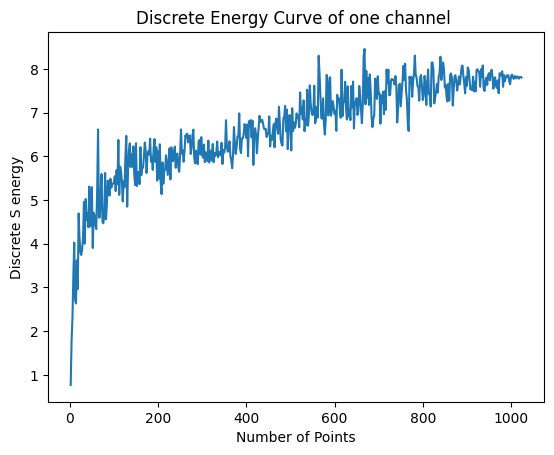

In [33]:
def plot_curve(WholeData, s):
    maxN = WholeData.shape[1]
    noSamples = mth.floor(maxN/2)
    
    channelData = WholeData[0,:] #single channel time series
    
    DataMat = np.zeros((maxN,2))
    DataMat[:,0] = 1/maxN*np.arange(maxN) #normalized times
    DataMat[:,1] = 1/np.max(np.abs(channelData))* channelData #normalized channel Data
    
    nArray, discSEnergyArray = DiscSEnergyCurves(maxN, s, DataMat, noSamples)
        
    plt.plot(nArray, discSEnergyArray)
    plt.xlabel('Number of Points')
    plt.ylabel('Discrete S energy')
    plt.title("Discrete Energy Curve of one channel ")

plot_curve(raw_seiz[:, 5000:5000 + 2**10], 1.7)

In [34]:
#too high prediction = raise cutoff, too low prediction = lower cutoff

motion = FBM(2048, 1, 0.2)[0].reshape((1, 2048))[0] 
#get_hurst_exponent(motion, max_lag=20)
hausdorff_binary_search(motion) #dependant on the number of points for some reason

NameError: name 'hausdorff_binary_search' is not defined

In [ ]:
def get_hurst_exponent(time_series, max_lag=20):
    """Returns the Hurst Exponent of the time series"""
    
    lags = range(2, max_lag)

    # variances of the lagged differences
    tau = [np.std(np.subtract(time_series[lag:], time_series[:-lag])) for lag in lags]

    # calculate the slope of the log plot -> the Hurst Exponent
    reg = np.polyfit(np.log(lags), np.log(tau), 1)

    return reg[0]

print(2 - get_hurst_exponent(raw_seiz[0, 1000:1000 + 2**10]))

In [ ]:
plt.plot(nArray, discSEnergyArray)
plt.xlabel('Number of Points')
plt.ylabel('Discrete S energy')
plt.title("Discrete Energy Curve of one channel ")

In [ ]:
import math

def hausdorff_binary_search(data, limits=(1, 2), resolution=0.02):
    low, high = limits
    while low + resolution < high: #add option to cut off search after a certain amount of time
        s = (low + high) / 2
        #take the average of the discrete energy of the points around the point of interest
        energy_1 = calc_energy(data, s, math.floor(len(data) / 4))
        energy_2 = calc_energy(data, s, len(data) - 5) #subtract the radius
        #run the convergance test
        #if it is evaluated to converge, low = s, else high = s
        if energy_1 > 0.75 * energy_2:
            low = s
        else:
            high = s
    return (low + high) / 2

def calc_energy(data, s, points, radius=2): #data is a 1d array
    #need to ensure radius does not go outside of the array
    N = len(data)
    total_energy = 0
    for p in range(points - radius, points + radius):
        increment = N / p
        indices = [math.floor(i*increment) for i in range(p)]
        sampled_points = data[indices]

        DataMat = np.zeros((p,2))
        DataMat[:,0] = 1/p*np.arange(p) #normalized times
        DataMat[:,1] = 1/np.max(np.abs(sampled_points))* sampled_points #normalized channel Data
    
        total_energy += DiscreteSEnergy(DataMat, s)[0]
    return total_energy / (radius * 2)

In [ ]:
channel = raw[0, :2048]
binary_guess = hausdorff_binary_search(channel)
hurst_guess = 2 - get_hurst_exponent(channel)
print(binary_guess, hurst_guess)

In [ ]:
plot_curve(raw_seiz[:, :2**10], 1.2)
plot_curve(raw_seiz[:, :2**10], 1.3)

In [ ]:
#2048 length, cutoff = 0.75. Length matters for some reason

error = 0
test_hursts = np.random.rand(50)
for i in range(len(test_hursts)):
    hurst = test_hursts[i]
    motion = FBM(2048, 1, hurst)[0].reshape((1, 2048))[0]
    binary_guess = hausdorff_binary_search(motion)
    error += abs(binary_guess - (2 - hurst))
    print(i, abs(binary_guess - (2 - hurst)))

print(error / len(test_hursts))

In [ ]:
log = []
for i in range(50):
    channel = raw[0, i * 2048:(i + 1) * 2048]
    binary_guess = hausdorff_binary_search(channel)
    hurst_guess = 2 - get_hurst_exponent(channel)
    log.append((binary_guess, hurst_guess))
    print(i, log[i])

In [ ]:
import matplotlib.pyplot as plt
plt.plot([i for i, j in log])
plt.plot([j for i, j in log])

In [ ]:
plt.plot(raw[0, :50*2048])
plt.plot([i*2048 for i in range(50)], [i / 800 - .002 for i, j in log])
plt.plot([i*2048 for i in range(50)], [j / 800 - .002 for i, j in log])

In [ ]:
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Time')
ax1.set_ylabel('Voltage')
ax1.plot(raw[0, :50*2048], color=color)
ax1.tick_params(axis='y')

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:orange'
ax2.set_ylabel('Estimated Hausdorff Dimension')  # we already handled the x-label with ax1
ax2.plot([i*2048 for i in range(50)], [i for i, j in log], color=color)
color = 'tab:green'
ax2.plot([i*2048 for i in range(50)], [j for i, j in log], color=color)
ax2.tick_params(axis='y')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [ ]:
plot_curve(raw[:, :2**11], 1.4)
plot_curve(raw[:, :2**11], 1.5)

In [ ]:
#T-tests
import pickle

seizure_times = pickle.load(open("seizure_times.pkl", "rb"))
seizure_data = []
non_seizure_data = []
for file in seizure_times.keys():
    data = mne.io.read_raw_edf("chb-mit-scalp-eeg-database-1.0.0\\" + file)
    raw = data.get_data()
    start, end = seizure_times[file][0]
    midpoint = (start + end) // 2
    if midpoint + 8 < end:
        seizure_data.append(raw[0, midpoint*256:midpoint*256 + 2048])
    non_seizure_data.append(raw[0, 30*256:38*256])

In [ ]:
seizure_dims = []
for i in range(len(seizure_data)):
    seizure_dims.append(hausdorff_binary_search(seizure_data[i]))
    print(i)
non_seizure_dims = []
for i in range(len(non_seizure_data)):
    non_seizure_dims.append(hausdorff_binary_search(non_seizure_data[i]))
    print(i)

In [ ]:
print(f"Average Hausdorff dimension for 121 \nsampled time periods during seizures:     {sum(seizure_dims) / 121}")
print(f"Average Hausdorff dimension for 140 \nsampled time periods not during seizures: {sum(non_seizure_dims) / 140}")